# Interpreting Random Forest model

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Setup

In [2]:
from tep.utils import load_array
X = load_array('data/meta_features_v3.bc')
X.shape

(1293005, 24)

In [3]:
y = load_array('data/log_labels_v3.bc')
y.shape

(1293005,)

In [4]:
import numpy as np
np.nan_to_num(X, copy=False)

array([[ 0.,  1.,  1., ...,  0.,  0.,  1.],
       [ 0.,  0.,  2., ...,  0.,  0.,  1.],
       [ 0.,  0.,  2., ...,  0.,  0.,  1.],
       ..., 
       [ 1.,  3.,  0., ...,  0.,  0.,  0.],
       [ 1.,  3.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  5.,  0.,  0.]])

In [5]:
X_train = X[:-10000]
y_train = y[:-10000]
X_valid = X[-10000:]
y_valid = y[-10000:]
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1283005, 24)
(10000, 24)
(1283005,)
(10000,)


## Define metrics

In [6]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, ret_scores=False):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    if ret_scores: return res

## Train model

In the previous notebook we tested several configurations of the random forest. The best performing model contained **40 estimators** with **minimum of eight samples per leaf**, trained on **70% of all features**.

In [7]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=8, max_features=0.7, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.6710590426886232, 0.8197595523551049, 0.9016210241298741, 0.85197166358650944, 0.84959397355649968]


## Calculate feature importance

In [8]:
import pandas as pd

def rf_feat_importance(m, feat_map):
    return pd.DataFrame({'cols':feat_map, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [9]:
from tep.featureGenerator import FeatureGenerator
fg = FeatureGenerator()

In [10]:
_, feat_map = fg.structured_feature_map()
feat_map

array(['urls', 'hashtags', 'mentions', 'length', 'sentiment', 'followers',
       'friends', 'follower_friend_ratio', 'verified', 'listings',
       'tweets', 'tweet_freq', 'favorites', 'favorite_freq', 'account_age',
       'month', 'day', 'weekday', 'hour', 'minute', 'quote',
       'quoted_popularity', 'quoted_sentiment', 'reply'],
      dtype='<U31')

In [11]:
rf_feat_importance(m, feat_map)

cols       imp
5               followers  0.428981
23                  reply  0.175498
9                listings  0.100391
7   follower_friend_ratio  0.039762
2                mentions  0.036998
10                 tweets  0.030384
14            account_age  0.027133
12              favorites  0.023326
3                  length  0.018047
11             tweet_freq  0.016389
13          favorite_freq  0.014337
6                 friends  0.012957
15                  month  0.011535
16                    day  0.010036
19                 minute  0.009714
18                   hour  0.009239
21      quoted_popularity  0.008440
4               sentiment  0.007696
0                    urls  0.006417
17                weekday  0.005753
1                hashtags  0.003465
20                  quote  0.002301
22       quoted_sentiment  0.000718
8                verified  0.000483

## Apply treeinterpreter

In [12]:
df_trn = pd.DataFrame(data=X, columns=feat_map)
df_trn.head()

urls  hashtags  mentions  length  sentiment  followers  friends  \
0   0.0       1.0       1.0   103.0   0.312500   443717.0    781.0   
1   0.0       0.0       2.0    37.0   0.000000    79503.0   2136.0   
2   0.0       0.0       2.0   119.0   0.610000  1524959.0   1353.0   
3   1.0       0.0       1.0   139.0  -0.500000   600213.0   7984.0   
4   1.0       1.0       0.0   132.0   0.112121   144853.0    937.0   

   follower_friend_ratio  verified  listings  ...    account_age  month   day  \
0             568.139565       1.0    2751.0  ...         3963.0    9.0   1.0   
1              37.220506       1.0    1020.0  ...         3648.0   11.0  13.0   
2            1127.094605       1.0   14295.0  ...         4429.0   11.0  28.0   
3              75.176979       1.0    4723.0  ...         3753.0    2.0  23.0   
4             154.592316       1.0    3463.0  ...         3522.0    7.0   6.0   

   weekday  hour  minute  quote  quoted_popularity  quoted_sentiment  reply  
0      3.0   9.0     9.0    0.0                0.0               0.0    1.0  
1      0.0  23.0    49.0    0.0                0.0               0.0    1.0  
2      1.0  20.0     5.0    0.0                0.0               0.0    1.0  
3      4.0  18.0    11.0    0.0                0.0               0.0    1.0  
4      3.0  11.0    26.0    0.0                0.0               0.0    0.0  

[5 rows x 24 columns]

In [13]:
def split_vals(a,n_val): return a[:-n_val], a[-n_val:]

In [14]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [71]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(m, X_valid[1:2])

In [72]:
print(prediction[0])
print(bias[0])
print(contributions[0])

3.121405459058773
1.8236454637542998
[-0.03816489 -0.03568983 -0.25982926  0.02382268  0.13959304 -0.42374356
  0.00413381  0.05350015  0.00297669 -0.31881984  0.4490997   0.38680565
  0.00845929  0.          0.78703153  0.01121192  0.12410323 -0.11099369
  0.06698308  0.10046898 -0.00085226 -0.07473995  0.00661019  0.39579331]


In [73]:
idxs = np.argsort(contributions[0])

In [74]:
[o for o in zip(df_trn.columns[idxs], df_trn.iloc[-9999][idxs], contributions[0][idxs])]

[('followers', 27193.0, -0.4237435603821543),
 ('listings', 642.0, -0.3188198355181118),
 ('mentions', 2.0, -0.2598292585046424),
 ('weekday', 3.0, -0.1109936914092661),
 ('quoted_popularity', 0.0, -0.07473995146083852),
 ('urls', 1.0, -0.03816488937751009),
 ('hashtags', 0.0, -0.03568982997297095),
 ('quote', 0.0, -0.0008522585378449077),
 ('favorite_freq', 1.4424635332252835, 0.0),
 ('verified', 1.0, 0.0029766878459554836),
 ('friends', 647.0, 0.004133808191799082),
 ('quoted_sentiment', 0.0, 0.006610193143970067),
 ('favorites', 890.0, 0.008459289233740364),
 ('month', 3.0, 0.011211923012183555),
 ('length', 140.0, 0.02382268056274154),
 ('follower_friend_ratio', 42.02936630602782, 0.053500154377050316),
 ('hour', 11.0, 0.06698307627387265),
 ('minute', 22.0, 0.1004689835981247),
 ('day', 2.0, 0.12410322998088832),
 ('sentiment', 0.0, 0.13959304358179886),
 ('tweet_freq', 4.8525121555915725, 0.3868056548405163),
 ('reply', 0.0, 0.3957933132292604),
 ('tweets', 2994.0, 0.449099703988

## Partial dependence plots

In [15]:
from pdpbox import pdp
from plotnine import *

In [16]:
df_pdp = df_trn.copy()
df_pdp.shape

(1293005, 24)

In [17]:
df_pdp['followers'] = np.log1p(df_pdp['followers'])
df_pdp['friends'] = np.log1p(df_pdp['friends'])
df_pdp['follower_friend_ratio'] = np.log1p(df_pdp['follower_friend_ratio'])
df_pdp['listings'] = np.log1p(df_pdp['listings'])
df_pdp['tweets'] = np.log1p(df_pdp['tweets'])
df_pdp['favorites'] = np.log1p(df_pdp['favorites'])
df_pdp['quoted_popularity'] = np.log1p(df_pdp['quoted_popularity'])
df_pdp['account_age'] = np.divide(df_pdp['account_age'], 365)

In [18]:
X_train, X_valid = split_vals(df_pdp, 10000); X_train.shape

(1283005, 24)

In [19]:
m_pdp = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.7, min_samples_leaf=8, oob_score=True)
m_pdp.fit(X_train, y_train)
print_score(m_pdp)

[0.6712548925945906, 0.8184388049398584, 0.90156359155366728, 0.85244826809017149, 0.84937252428340371]


In [20]:
sample = get_sample(X_train, 1000)

In [21]:
def plot_pdp(m, x, feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None, n_cluster_centers=clusters)

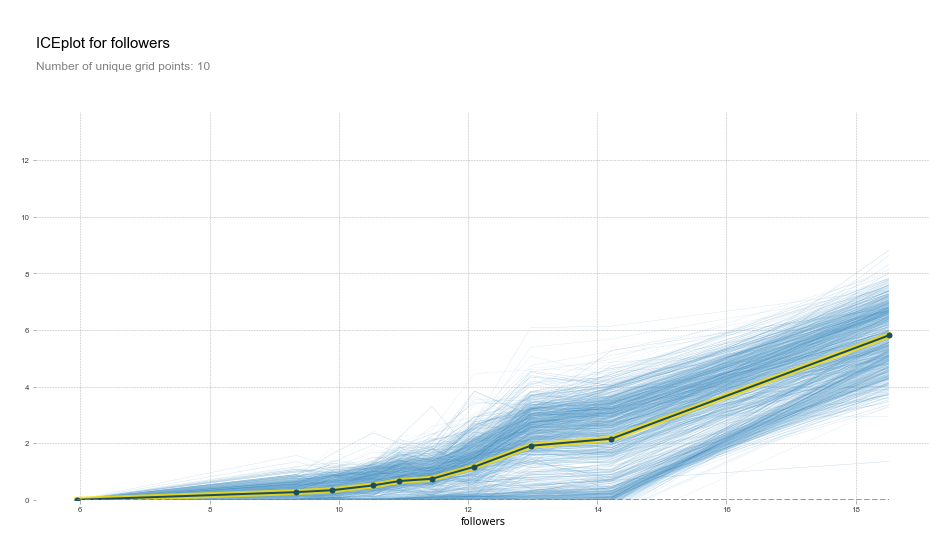

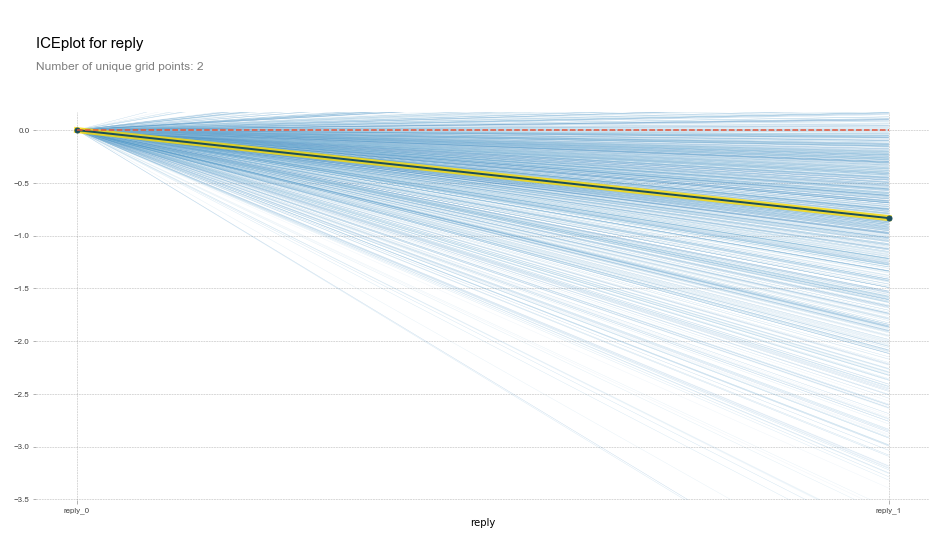

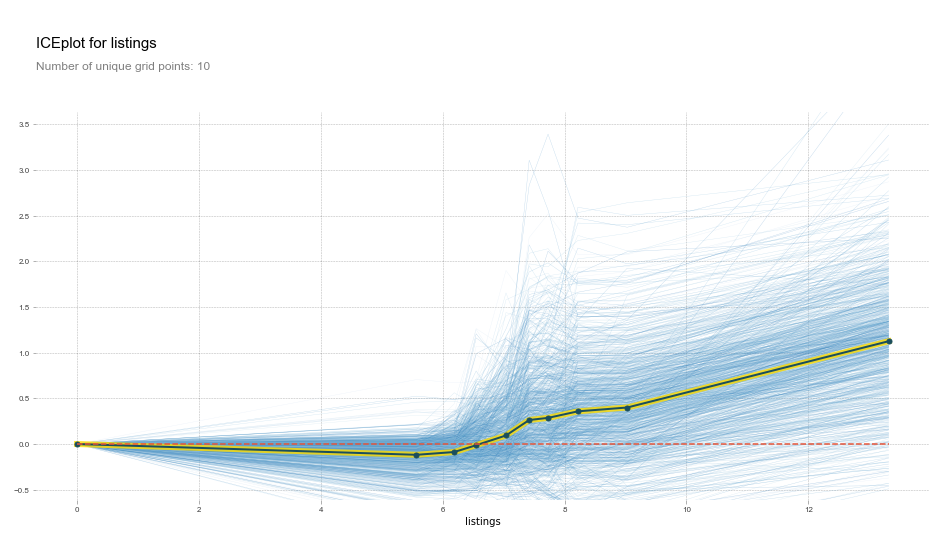

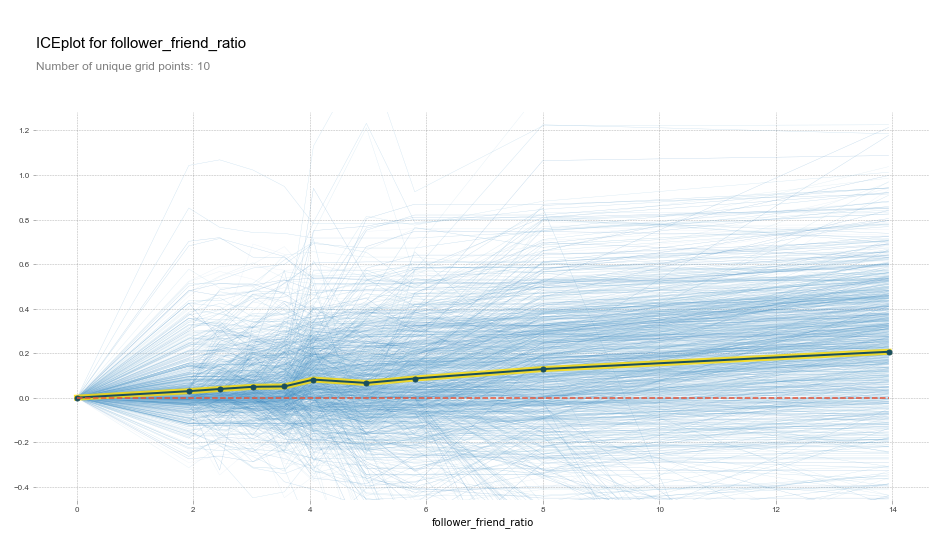

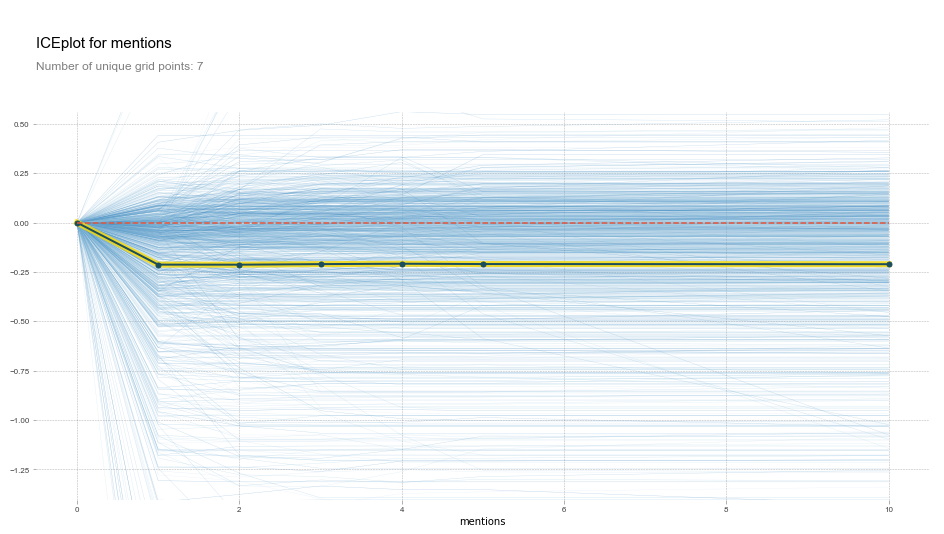

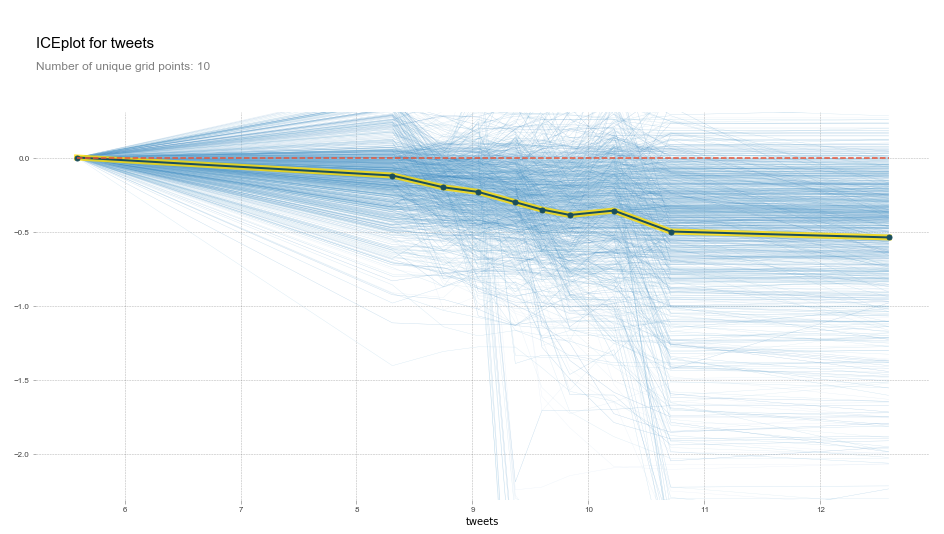

In [22]:
imp_feats = ['followers', 'reply', 'listings', 'follower_friend_ratio', 'mentions', 'tweets']
for feat in imp_feats:
    plot_pdp(m_pdp, sample, feat)

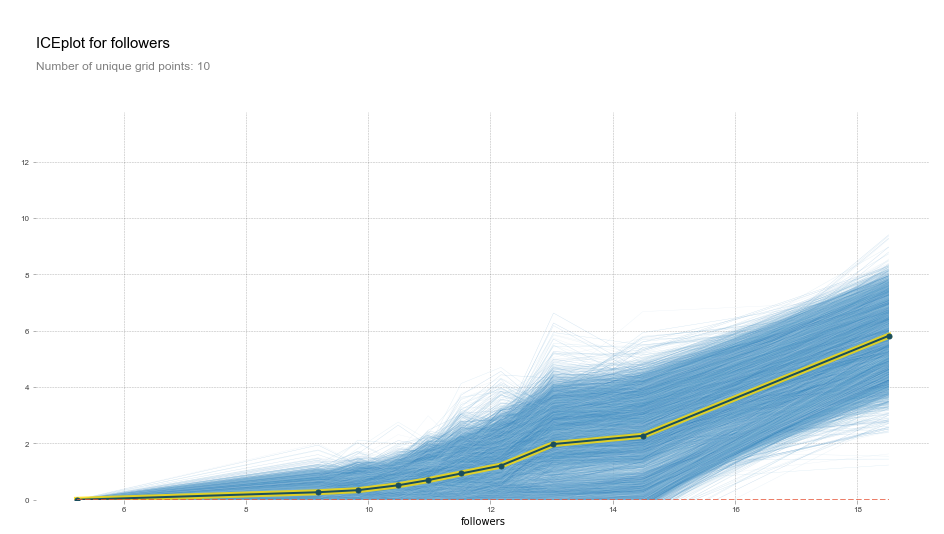

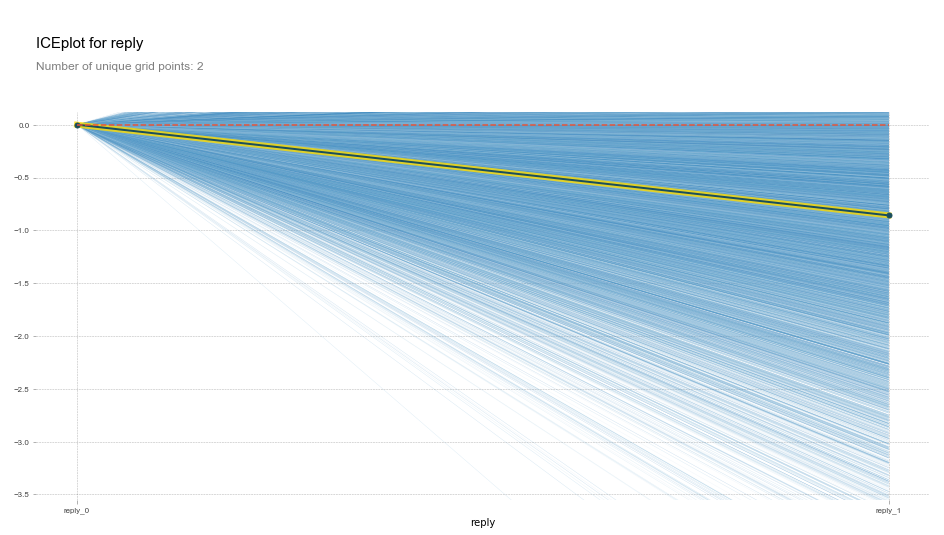

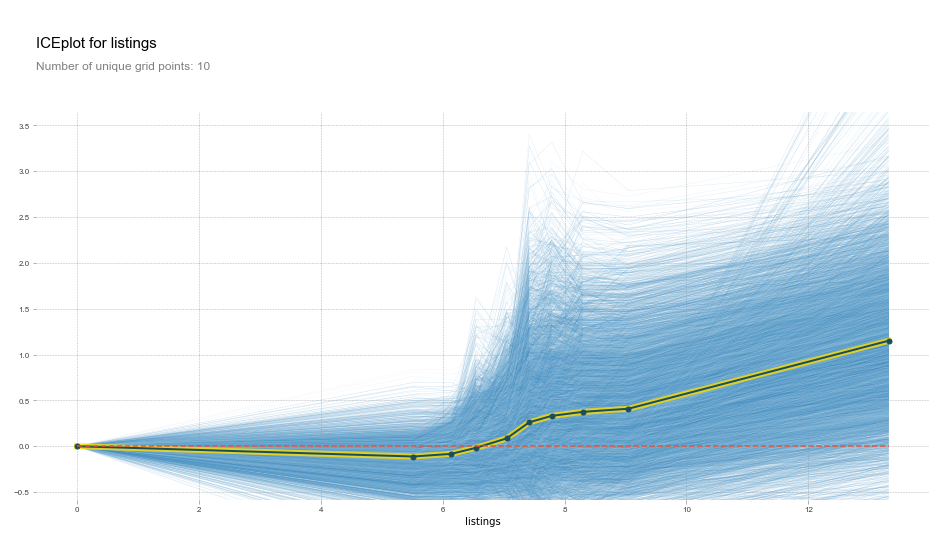

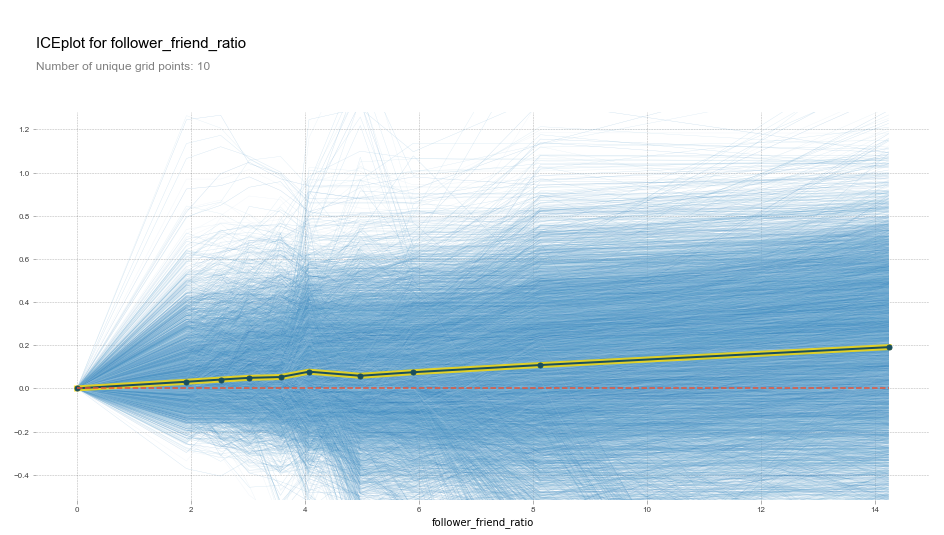

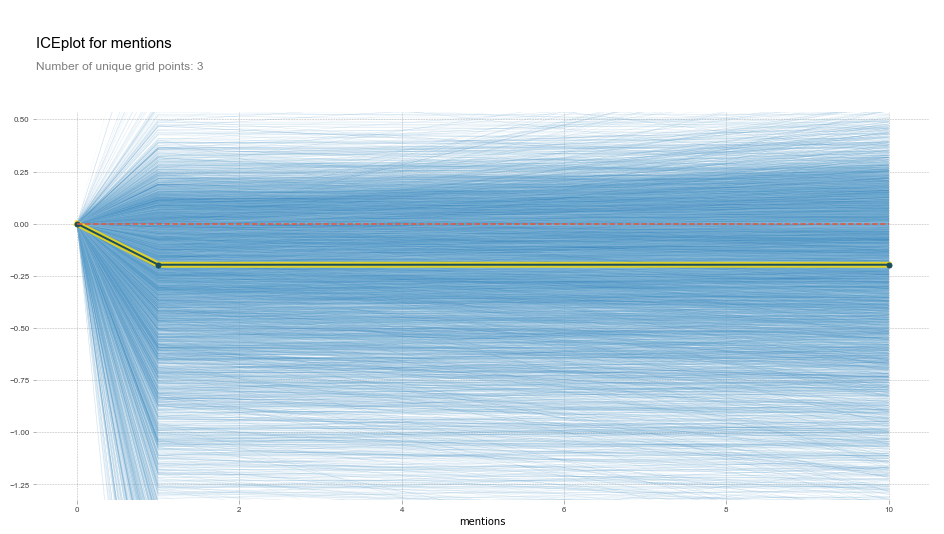

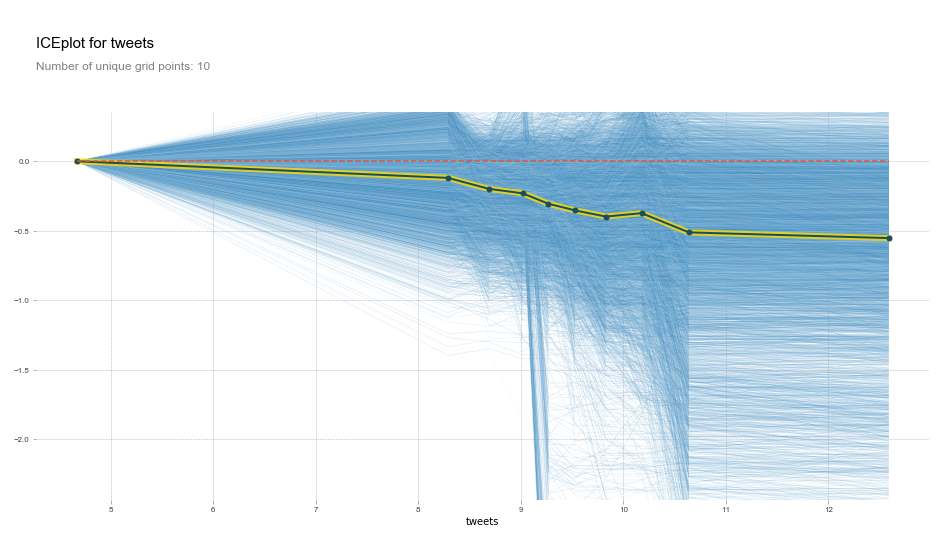

In [23]:
imp_feats = ['followers', 'reply', 'listings', 'follower_friend_ratio', 'mentions', 'tweets']
for feat in imp_feats:
    plot_pdp(m_pdp, X_valid, feat)